<a href="https://colab.research.google.com/github/zhanmdd/glassdoor-reviews-sentiment-BERT/blob/master/Glassdoor_Reviews_Preprocessing_and_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup and Loading The Dataset

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 3.0MB 19.1MB/s 
     |████████████████████████████████| 890kB 16.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=08c11c2df2266da405c419369637bcccadd3e5910f755c058b9671c0fd614aae
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
from transformers import BertTokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F

from google.colab import files
import io

device = torch.device("cuda:0" if torch.cuda.is_available() else "Couldn't find GPU device")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

In [ ]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['df_cleaned.csv']))
df.head()

Saving df_cleaned.csv to df_cleaned.csv


,company_name,employee_title,employee_status,state,city,date,rating,sentiment,review
0,CoStar-Group,Market Research Analyst II,Current Employee,VA,Richmond,2020-01-22 08:38:01,5.0,2,Best company I had ever worked for in 3 decade...
1,CoStar-Group,Inside Sales Representative,Current Employee,NaN,NaN,2020-07-16 10:23:06,5.0,2,Great Place to Make Money. I have been working...
2,CoStar-Group,Inside Sales Representative,Current Employee,DC,Washington,2020-07-16 10:49:00,5.0,2,Great place to start a career and make money. ...
3,CoStar-Group,Senior Account Manager,Former Employee,DC,Washington,2020-07-15 11:13:00,4.0,2,Great Company. I worked at CoStar Group full-t...
4,CoStar-Group,Tenant Research Associate,Current Employee,VA,Richmond,2020-07-21 17:49:46,2.0,0,DO NOT GET SUCKED FOR THE MONEY!!!I have been ...


In [ ]:
df.shape

(10124, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124 entries, 0 to 10123
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company_name     10124 non-null  object 
 1   employee_title   5926 non-null   object 
 2   employee_status  10124 non-null  object 
 3   state            6103 non-null   object 
 4   city             6103 non-null   object 
 5   date             10124 non-null  object 
 6   rating           10124 non-null  float64
 7   sentiment        10124 non-null  int64  
 8   review           10124 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 712.0+ KB


##Pre-Processing

Steps:
1. Tokenize
2. Format specifically for BERT model

BERT Model Requierements:
1. **Add special tokens** to specify separations and specify the task of classification (example of the special tokens: 'SEP', 'CLS', 'PAD', 'UNK')
2. **Truncate and pad sentences** to a one common length
3. **Create an attention mask** to specify a pad token (0-not referring to any word) and an actual token (1-referring to a word)

###Picking ``` MAX_LEN ``` (sequence length)

The higher ``` MAX_LEN ```, the more accurate our model in a specific case. However, a too high value slows down total trainig time and makes the model fail to generalize (overfitting).

What we going to do is:

1. Figure out initial optimal
2. Experiment and pick most optimal





**Loading the model and the tokenizer**
<p>We'll be using Bert Base Cased model, which has 12 encoders and takes casing into account.<p>Why "cased" when usually it's "uncased"? Because in our case of analyzing reviews, for example, "I LOVE IT" expresses a stronger sentiment than "I love it"

In [ ]:
bert_cased = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_cased)

 We will pick the initial ``` MAX_LEN ``` by examining the distribution of token lengths and picking the most optimal at a first glance: "Not too big... Not too small"

In [ ]:
lengths = []

for review in df.review:
  tokens = tokenizer.encode(review, truncation=True, max_length=512)
  lengths.append(len(tokens))

lens = pd.DataFrame(lengths)
lens.describe()

,0
count,10124.000000
mean,114.978467
std,104.471839
min,24.000000
25%,48.000000
50%,77.000000
75%,136.000000
max,512.000000


Average length is around 115 and standard deviation is around 104.5. I'd pick average, but it cause some iformation loss. To be safe, I'll pick **170**.

In [ ]:
MAX_LEN = 170

###Special Tokens. Padding. Attention Mask.

PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset
class create_dataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoder = self.tokenizer.encode_plus(
      review,
      truncation = True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'targets': torch.tensor(target, dtype=torch.long),
      'input_ids': encoder['input_ids'].flatten(),
      'attention_mask': encoder['attention_mask'].flatten()
    }

Splitting data into train, test, validation sets

In [ ]:
random_seed = 123
df_train, df_test = train_test_split(df, test_size=0.15, random_state = random_seed)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state = random_seed)

Let's create Data Loaders to avoid syntax mistakes and to simplify the process

In [ ]:
from torch.utils.data import DataLoader
def create_dataloader(df, tokenizer, max_len, batch_size):
  ds = create_dataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds, batch_size=batch_size, num_workers=4)

When tuning the model for a specific task, authors recommends to use a batch size of 16 or 32

In [ ]:
BATCH_SIZE = 32

dataloader_train = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
dataloader_val = create_dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
dataloader_test = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

##Building and Training Model

###Create a classifier

In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
pretrained_bert = BertModel.from_pretrained(bert_cased)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_cased)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
cls_model = SentimentClassifier(3)
cls_model = cls_model.to(device)

###Training the Model

With more AdamW is an optimizer provided by Hugging Face Library. Shortly, it helps to accelerate training and avoid weight decay. We train the model by utilizing linear scheduler, but without warmup steps (num_warmup_steps).
Authors suggest using 2, 3, or 4 epochs. I'll use 4.

In [ ]:
EPOCHS = 4

optimizer = AdamW(cls_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(dataloader_train) * EPOCHS
ln_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=total_steps)
loss_func = nn.CrossEntropyLoss().to(device)

In [ ]:
def training_epochs( model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = cls_model.train()

  losses = []
  correct_preds = 0
  
  for x in data_loader:
    input_ids = x["input_ids"].to(device)
    attention_mask = x["attention_mask"].to(device)
    targets = x["targets"].to(device)

    outputs = model(input_ids=input_ids,attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_preds += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_preds.double() / n_examples, np.mean(losses)

In [ ]:
def evaluate_model(model, data_loader, loss_fn, device, n_examples):
  model = cls_model.eval()

  losses = []
  correct_preds = 0

  with torch.no_grad():
    for x in data_loader:
      input_ids = x["input_ids"].to(device)
      attention_mask = x["attention_mask"].to(device)
      targets = x["targets"].to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_preds += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_preds.double() / n_examples, np.mean(losses)

In [ ]:
%%time


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'===== EPOCH {epoch + 1}/{EPOCHS} =====')

  acc_train, loss_train = training_epochs(cls_model, dataloader_train, loss_func, optimizer, device, ln_scheduler, len(df_train))

  print(f'Train loss {loss_train} accuracy {acc_train}')

  acc_val, loss_val = evaluate_model(cls_model, dataloader_val, loss_func, device, len(df_val))

  print(f'Val loss {loss_val} accuracy {acc_val}')
  print('')

  history['acc_train'].append(acc_train)
  history['loss_train'].append(loss_train)
  history['acc_val'].append(acc_val)
  history['loss_val'].append(loss_val)

  if acc_val > best_accuracy:
    torch.save(cls_model.state_dict(), 'best_model_state.bin')
    best_accuracy = acc_val

===== EPOCH 1/4 =====
Train loss 0.65569364016384 accuracy 0.726205694363742
Val loss 0.5580893804629644 accuracy 0.7786561264822135

===== EPOCH 2/4 =====
Train loss 0.4119096614946663 accuracy 0.8353282975014527
Val loss 0.6015690509229898 accuracy 0.7865612648221344

===== EPOCH 3/4 =====
Train loss 0.2764161747212082 accuracy 0.895642068564788
Val loss 0.6881636890272299 accuracy 0.7773386034255599

===== EPOCH 4/4 =====
Train loss 0.1785421982116748 accuracy 0.9417780360255665
Val loss 0.7736372190217177 accuracy 0.7681159420289856

CPU times: user 18min 35s, sys: 11min 40s, total: 30min 16s
Wall time: 30min 26s


In [ ]:
best_accuracy

tensor(0.7866, device='cuda:0', dtype=torch.float64)

The highest accuracy of 78.6% was on the 2nd epoch

##Evaluating Our Model

###Creating a funtion to get predictions

We got our test set and now we can run our fine-tuned model to generate predictions on the set.
Let's get the accuracy on the test set.

In [ ]:
acc_test, _ = evaluate_model(cls_model, dataloader_test, loss_func, device, len(df_test))
acc_test.item()

0.7671052631578947

The accuracy on the Test set is around 2% lower. Let's try to look deeper and evaluate our model.

In [ ]:
def get_predictions(model, data_loader):
  model = cls_model.eval()
  
  reviews = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      reviews.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return reviews, predictions, prediction_probs, real_values

This function gets us reviews with their prediction probabilities and we can use them to see

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(cls_model,dataloader_test)

###Confusion Matrix and Visualization

In [ ]:
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80       223
     neutral       0.43      0.49      0.46       140
    positive       0.88      0.85      0.87       397

    accuracy                           0.77       760
   macro avg       0.71      0.71      0.71       760
weighted avg       0.78      0.77      0.77       760



The confusion matrix clearly shows us that our model classifies reviews with a 'positive' and 'negative' sentiment with hight acuracy. However, it fails to accurately classify reviews with neutral sentiment.

Let's create a heatmap. Hopefully, the heatmap will show the result clearer.

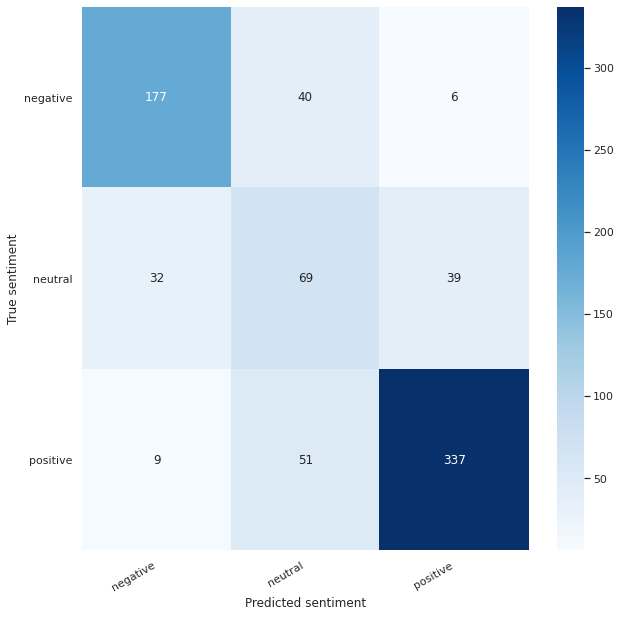

In [ ]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(10,10))
  sns.set(style='darkgrid')
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive'])
show_confusion_matrix(df_cm)

###Results and Insights

Overall, our model is most accurate at classifying a **positive** sentiment, slightly less accurate at classifying **negative** sentiment, and very flawed at classifying a **neutral** sentiment. 

Initially, in order to improve accuracy, I tried to tune the model differently and experiment with it. However, this didn't affect the results significantly. After some observations, I realized the data I was feeding affected the result. Let's take a look at the tables.

In [103]:
nums = [[177, 69, 337], [2815,	1857,	5452]]
d = pd.DataFrame(nums)
d = d.rename(columns={0:'negative',1:'neutral',2:'positive'}, index={0:'num_cor_clas', 1:'num_rev_df'})
d

,negative,neutral,positive
num_cor_clas,177,69,337
num_rev_df,2815,1857,5452


In [107]:
nums = [[177, 69, 337], [2815,	1857,	5452]]
d = pd.DataFrame(nums)
d[3] = d[0]+d[1]+d[2]
d.loc[0] = d.loc[0]/d.loc[0][3]
d.loc[1] = d.loc[1]/d.loc[1][3]
d = d.drop(columns = [3])
d = d.rename(columns={0:'negative',1:'neutral',2:'positive'}, index={0:'num_cor_clas', 1:'num_rev_df'})
d

,negative,neutral,positive
num_cor_clas,0.303602,0.118353,0.578045
num_rev_df,0.278052,0.183426,0.538522


As you can see, each fraction of the total correctly classified reviews is roughly equal to each fraction of total reviews in our dataset.
This means that our model didn't get enough data with neutral and negative sentiments to train on, to be as good at classifying the neutral and negative reviews as   positive reviews.

##Conclusion

Let's summarize what we have done so far.

1. Pre-processed our cleaned dataset
2. Built and trained the BERT model on Train set
3. Evaluated the model on Test set
4. Measured the accuracy of our model: precision, recall,  f1-score
5. Found the reason why our model failed to classify the neutral and negative sentiments as good as positive sentiment



#Credit

Thanks to [Venelin Valkov](https://github.com/curiousily)'s clear tutorial and logical coding style at [Getting-Things-Done-with-Pytorch](https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb)
